## Resnet demo

Build a resnet  from scratch and compare to torchvision model.

In [1]:
import torch.utils.model_zoo as model_zoo
import torchvision

from gamma import *
from gamma.torch import *
from gamma.models import *

#### 1. Load pre-trained weights from torch model zoo

In [2]:
depth=50

In [3]:
model_name = f'resnet{depth}'
state_dict = model_zoo.load_url(torchvision.models.resnet.model_urls[model_name])
name_rules = [
    ('conv1.{}', 'prep/conv/{}'),
    ('bn1.{}',   'prep/bn/{}'),
    ('layer{}.{}.downsample.0.{}', 'layer_{}/block_{}/downsample/conv/{}'),
    ('layer{}.{}.downsample.1.{}', 'layer_{}/block_{}/downsample/bn/{}'),
    ('layer{}.{j}.conv{k}.{}', 'layer_{}/block_{j}/conv_{k}/conv/{}'),
    ('layer{}.{j}.bn{k}.{}', 'layer_{}/block_{j}/conv_{k}/bn/{}'),
    ('fc.{}', 'classifier/{}')
]

state_dict = rename(state_dict, name_rules)
state = {n: (constant(v.data, tuple(v.size())), []) for n, v in state_dict.items()}
draw(state, direction='TB')

#### 2. Network description

In [4]:
net_initial, rules, net = resnet(depth, num_classes=1000)

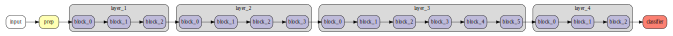

In [5]:
draw(net_initial)

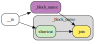

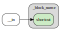

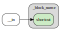

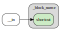

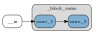

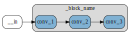

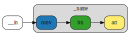

In [6]:
for r in rules: draw(r)

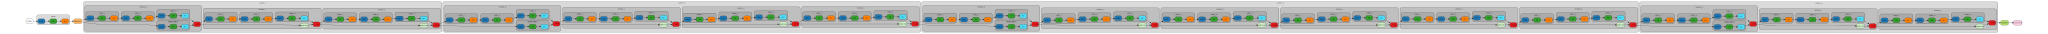

In [7]:
draw(net)

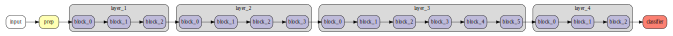

In [8]:
draw(apply_rules(net, [reverse(r) for r in reversed(rules)]))

#### 3. Build torch module and load weights

In [9]:
torch_net = apply_rules(net, torch_rules())
model = TorchGraph(torch_net).train()
load_state(model, state_dict, sep='/')

#### 4. Test

In [10]:
from numpy.testing import assert_almost_equal

torch_model = getattr(torchvision.models, model_name)(pretrained=True).train()
inputs, targets = torch.rand((2, 3, 224, 224)), torch.randint(0, 1000, (2,), dtype=torch.int64)

output = model({'input': inputs, 'target': targets})
torch_output = torch_model(inputs)

assert_almost_equal(to_numpy(output['classifier']), to_numpy(torch_output), decimal=6)
print('Success!')

Success!
